# 기본 설정

In [49]:
import re
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from datasets import (
    Dataset,
    load_from_disk,
    concatenate_datasets,
)
from transformers import AutoConfig, AutoModelForQuestionAnswering, AutoTokenizer
from pprint import pprint
import matplotlib.pyplot as plt
from konlpy.tag import Mecab
from collections import Counter

In [5]:
mecab = Mecab()
print(mecab.morphs("아버지가방에들어가신다"))
print(mecab.pos("아버지가방에들어가신다"))

['아버지', '가', '방', '에', '들어가', '신다']
[('아버지', 'NNG'), ('가', 'JKS'), ('방', 'NNG'), ('에', 'JKB'), ('들어가', 'VV'), ('신다', 'EP+EC')]


In [6]:
wiki_data_path = "../data/wikipedia_documents.json"

In [7]:
wiki_data = pd.read_json(wiki_data_path)
wiki_data

,0,1,2,3,4,5,6,7,8,9,...,60603,60604,60605,60606,60607,60608,60609,60610,60611,60612
text,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,"아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...",저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,아오조라 문고는 자원봉사로 운영되며 열람 역시 무료이다. 서비스 개시 초반에는 보...,"텍스트 파일을 아오조라 문고에 수록할 때, 텍스트 파일이 갖추어야 할 서식을 '아오...",일본어 표기에 많이 쓰이는 올림문자 (후리가나)는 그대로 올려쓰지 않고 '｜'나 '...,켄 톰슨(Ken Thompson) 등과 함께 최초의 유닉스(Unix) 시스템을 개발...,"주기율표(週期律表, 주기률표, periodic table) 또는 주기표(週期表)는 ...",...,"재래식 전력과 비대칭 전력, 즉 핵까지 갖고 있다한 들, 독자적으로 GPS(GNSS...","소련은 1960년 10월, 알제리를 독립 정부로 최초로 인정해준 나라였다. 소련이 ...","미국 안보 매체, 내셔널 인터레스트지는 한국군이 국방비를 늘렸다고, 비스트 모드(짐...","곰 자체는 페름 지역 숲에 사는 동물이 풍부함을 상징하며, 은색인 이유는 금속, 소...","1967년 소련 통치기 페름 시 의회는 새 문장 공모전을 개최하였으며, 1968년까...","오키나와 현립 박물관·미술관( , Okinawa Prefectural Museum ...","1936년 7월, 오키나와현 교육위원회 부설 향토 박물관(沖縄県教育会附設郷土博物館)...",박물관은 개관 10주년이되는 2017년에 관의 애칭 및 마스코트를 일반인에게 공모했...,단결권 및 단체교섭권 협약(Right to Organise and Collectiv...,이 협약은 부당노동행위 제도를 규율하고 있다. 협약 제1조에서 반노동조합 차별행위로...
corpus_source,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,...,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아,위키피디아
url,TODO,TODO,TODO,TODO,TODO,TODO,TODO,TODO,TODO,TODO,...,None,None,None,None,None,None,None,None,None,None
domain,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
title,나라 목록,나라 목록,백남준,아오조라 문고,아오조라 문고,아오조라 문고,아오조라 문고,아오조라 문고,데니스 리치,주기율표,...,자주국방론,자주국방론,자주국방론,페름의 문장,페름의 문장,오키나와 현립 박물관·미술관,오키나와 현립 박물관·미술관,오키나와 현립 박물관·미술관,단결권 및 단체교섭권 협약,단결권 및 단체교섭권 협약
author,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
html,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
document_id,0,1,2,3,4,5,6,7,8,9,...,60603,60604,60605,60606,60607,60608,60609,60610,60611,60612


In [8]:
wiki_data = wiki_data.T
wiki_data

,text,corpus_source,url,domain,title,author,html,document_id
0,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",위키피디아,TODO,None,나라 목록,None,None,0
1,이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,위키피디아,TODO,None,나라 목록,None,None,1
2,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,위키피디아,TODO,None,백남준,None,None,2
3,"아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...",위키피디아,TODO,None,아오조라 문고,None,None,3
4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4
...,...,...,...,...,...,...,...,...
60608,"오키나와 현립 박물관·미술관( , Okinawa Prefectural Museum ...",위키피디아,None,None,오키나와 현립 박물관·미술관,None,None,60608
60609,"1936년 7월, 오키나와현 교육위원회 부설 향토 박물관(沖縄県教育会附設郷土博物館)...",위키피디아,None,None,오키나와 현립 박물관·미술관,None,None,60609
60610,박물관은 개관 10주년이되는 2017년에 관의 애칭 및 마스코트를 일반인에게 공모했...,위키피디아,None,None,오키나와 현립 박물관·미술관,None,None,60610
60611,단결권 및 단체교섭권 협약(Right to Organise and Collectiv...,위키피디아,None,None,단결권 및 단체교섭권 협약,None,None,60611


In [9]:
wiki_data_text = wiki_data["text"]
wiki_data_text


0        이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...
1        이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...
2        현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...
3        아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...
4        저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...
                               ...                        
60608    오키나와 현립 박물관·미술관( , Okinawa Prefectural Museum ...
60609    1936년 7월, 오키나와현 교육위원회 부설 향토 박물관(沖縄県教育会附設郷土博物館)...
60610    박물관은 개관 10주년이되는 2017년에 관의 애칭 및 마스코트를 일반인에게 공모했...
60611    단결권 및 단체교섭권 협약(Right to Organise and Collectiv...
60612    이 협약은 부당노동행위 제도를 규율하고 있다. 협약 제1조에서 반노동조합 차별행위로...
Name: text, Length: 60613, dtype: object

In [10]:
train_data_path = "../data/train_dataset"
train_data = load_from_disk(train_data_path)
train_data

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 240
    })
})

In [11]:
train_data["train"][0]

{'title': '미국 상원',
 'context': '미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\\n\\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\\n\\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05',
 'question': '대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?',
 'id': 'mrc-1-000067',
 'answers': {'answer_start'

In [12]:
train_data["validation"][0]

{'title': '전효숙',
 'context': '순천여자고등학교 졸업, 1973년 이화여자대학교를 졸업하고 1975년 제17회 사법시험에 합격하여 판사로 임용되었고 대법원 재판연구관, 수원지법 부장판사, 사법연수원 교수, 특허법원 부장판사 등을 거쳐 능력을 인정받았다. 2003년 최종영 대법원장의 지명으로 헌법재판소 재판관을 역임하였다.\\n\\n경제민주화위원회(위원장 장하성이 소액주주들을 대표해 한보철강 부실대출에 책임이 있는 이철수 전 제일은행장 등 임원 4명을 상대로 제기한 손해배상청구소송에서 서울지방법원 민사합의17부는 1998년 7월 24일에 "한보철강에 부실 대출하여 은행에 막대한 손해를 끼친 점이 인정된다"며 "원고가 배상을 청구한 400억원 전액을 은행에 배상하라"고 하면서 부실 경영인에 대한 최초의 배상 판결을 했다. \\n\\n2004년 10월 신행정수도의건설을위한특별조치법 위헌 확인 소송에서 9인의 재판관 중 유일하게 각하 견해를 내었다. 소수의견에서 전효숙 재판관은 다수견해의 문제점을 지적하면서 관습헌법 법리를 부정하였다. 전효숙 재판관은 서울대학교 근대법학교육 백주년 기념관에서 열린 강연에서, 국회가 고도의 정치적인 사안을 정치로 풀기보다는 헌법재판소에 무조건 맡겨서 해결하려는 자세는 헌법재판소에게 부담스럽다며 소회를 밝힌 바 있다.',
 'question': '처음으로 부실 경영인에 대한 보상 선고를 받은 회사는?',
 'id': 'mrc-0-003264',
 'answers': {'answer_start': [284], 'text': ['한보철강']},
 'document_id': 9027,
 '__index_level_0__': 2146}

In [13]:
test_data_path = "../data/test_dataset"
test_data = load_from_disk(test_data_path)
test_data

DatasetDict({
    validation: Dataset({
        features: ['id', 'question'],
        num_rows: 600
    })
})

In [14]:
test_data["validation"][0]

{'question': "유령'은 어느 행성에서 지구로 왔는가?", 'id': 'mrc-1-000653'}

# Tokenizer 설정

In [15]:
model_name = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

PreTrainedTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [16]:
tokenizer(wiki_data.iloc[0]["text"])

{'input_ids': [2, 1504, 6953, 2259, 3779, 10188, 2052, 2307, 16, 1537, 3665, 21732, 2019, 3779, 2079, 544, 6994, 2145, 10356, 5887, 3766, 2138, 20245, 4337, 2200, 15346, 19521, 1513, 2062, 18, 1504, 10188, 2073, 17834, 2267, 2138, 3627, 864, 3884, 6233, 9928, 2051, 1513, 2062, 18, 7, 1656, 1141, 3135, 3884, 2073, 27209, 13026, 2145, 13865, 2069, 3954, 7488, 6125, 886, 3854, 5255, 2170, 4502, 2496, 2051, 3854, 31221, 5887, 2069, 7204, 1122, 2886, 4683, 3776, 2259, 6012, 2019, 3779, 2138, 15346, 19521, 1513, 2062, 18, 7, 864, 1141, 3135, 3884, 2073, 3951, 3634, 2079, 10356, 2069, 5761, 12, 842, 1827, 2386, 13, 3925, 19521, 1513, 3683, 16, 3919, 3854, 31221, 5887, 2069, 7204, 1122, 2118, 1380, 2886, 4683, 3776, 2259, 3718, 2019, 3779, 2138, 15346, 19521, 1513, 2062, 18, 864, 10188, 2073, 3702, 15519, 2062, 8066, 2062, 18, 3951, 3728, 2079, 3640, 3728, 2200, 2112, 2079, 5109, 2170, 6851, 2079, 4588, 2116, 1513, 4007, 16, 1504, 3624, 2170, 3839, 2470, 10188, 2069, 1430, 2259, 575, 2073, 423

In [17]:
tokenizer_test = wiki_data.iloc[3]["text"]
print(tokenizer_test)
print(tokenizer.tokenize(tokenizer_test))

아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로젝트’로 불리는 일본의 인터넷 전자도서관으로, 저작권이 풀린 문학작품을 수집, 전자문서화해서 인터넷에 공개하고 있다. 저자 사후 50년이 지난 메이지, 쇼와 시대 초기의 일본 문학 작품이 그 대부분을 차지하고 있고, 일본어 외 문학 작품의 일본어 번역 작품도 다수 있다. 1997년 2월 도미타 미치오, 노구치 에이치, 야마키 미에, 란무로 사테이 등 4명이 창설하여 시작되었다.  2016년 연간 방문객수는 940만 건 이상이다. 

아오조라 문고에 수록된 작품은 JIS X 0208에 해당되는 한자 범위 내에서 자원봉사자에 의해 아오조라 문고 형식 텍스트파일이나 HTML 파일로 전자화된다. 또 아오조라 문고 수록파일 취급기준에 따라 자유롭게 이용할 수 있기 때문에, 수록된 작품을 PC는 물론 PDA와 휴대전화로도 볼 수 있다. 텍스트 파일을 큰 글자로 인쇄하거나 전용 소프트웨어에 불러들여 시각장애인용으로 이용하는 방안도 기대되고 있다. 아오조라 문고의 열람 소프트웨어는 따로 개발 및 제공되고 있는 것은 없지만, 전자사전이나 아이폰용 어플리케이션 등은 타사에서 개발하여 출시되어 있다
['아오', '##조', '##라', '문고', '(', '靑', '空', '文', '[UNK]', ',', '[UNK]', '|', '아오', '##조', '##라', '분', '##고', ')', '는', '‘', '일본어', '##판', '구', '##텐', '##베르크', '프로젝트', '’', '로', '불리', '##는', '일본', '##의', '인터넷', '전자', '##도', '##서관', '##으로', ',', '저작권', '##이', '풀린', '문학', '##작', '##품', '##을', '수집', ',', '전자', '##문', '##서', '##화', '##해서', '인터넷', '##에', '공개', '##하고', '있', '##다', '.', '저자', '사후', '50', 

# PreProcessing
## train_data_answers에서 한글, 영어, 숫자 제외한 문자는 어떠한 것들이 있는가?

In [37]:
train_other_char = []
p = re.compile(r"[^ ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z]")
for row in train_answers:
    text = row["text"][0]
    if p.findall(text) != []:
        train_other_char.extend(p.findall(text))

train_other_char = list(set(train_other_char))
print(sorted(train_other_char))
print(len(train_other_char))

['!', '"', '%', "'", '(', ')', '+', ',', '-', '.', '/', ':', '<', '>', '~', '\xad', '°', '·', 'ä', '‘', '’', '“', '”', '∧', '≪', '≫', '〈', '〉', '《', '》', '「', '」', '『', '』', 'い', 'う', 'し', 'な', 'に', 'の', 'よ', 'ら', '・', '一', '之', '二', '京', '信', '優', '儼', '公', '冬', '刀', '分', '前', '割', '劉', '務', '勳', '北', '匡', '南', '卵', '原', '受', '呂', '坂', '城', '堂', '塔', '塡', '壇', '夔', '大', '太', '奎', '媒', '孟', '學', '宋', '害', '寺', '平', '康', '式', '張', '弼', '循', '心', '忠', '念', '性', '意', '愛', '成', '扶', '文', '日', '月', '有', '格', '槪', '次', '毅', '池', '汪', '河', '流', '海', '淵', '淸', '片', '牲', '狼', '王', '理', '琿', '甚', '田', '監', '祚', '祠', '祭', '縣', '總', '肥', '臺', '興', '華', '蓮', '蔣', '藏', '識', '資', '超', '趙', '身', '軍', '輪', '辣', '遷', '部', '郵', '鄭', '釋', '重', '金', '鉱', '限', '陳', '陵', '陽', '雲', '餘', '駅', '魯', '麻', '＜', '＞']
159


In [38]:
validation_other_char = []
for row in validation_answers:
    text = row["text"][0]
    if p.findall(text) != []:
        validation_other_char.extend(p.findall(text))

validation_other_char = list(set(validation_other_char))
print(sorted(validation_other_char))
print(len(validation_other_char))

['"', "'", '(', ')', ',', '.', ':', '·', 'ć', '‘', '’', '“', '”', '〈', '〉', '《', '》', '『', '』', '之', '呂', '成', '戰', '果', '楊', '正', '物', '田', '的', '肉', '色', '西', '鉉', '陳', '黑', '黨', '齊', '＜', '＞']
39


In [22]:
wiki_other_char = []
for row in wiki_data_text:
    if p.findall(row) != []:
        wiki_other_char.extend(p.findall(row))

wiki_other_char = list(set(wiki_other_char))
print(sorted(wiki_other_char))
print(len(wiki_other_char))

['\t', '\n', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '\x7f', '\x95', '\xa0', '¡', '¢', '£', '¥', '§', '¨', '«', '¬', '\xad', '®', '°', '±', '²', '³', '´', 'µ', '¶', '·', '¹', 'º', '»', '¼', '½', '¾', '¿', 'À', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Í', 'Î', 'Ñ', 'Ó', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ú', 'Ü', 'Þ', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', '÷', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'þ', 'ÿ', 'Ā', 'ā', 'ă', 'ą', 'ć', 'Ĉ', 'ĉ', 'Č', 'č', 'ď', 'Đ', 'đ', 'Ē', 'ē', 'ė', 'ę', 'ě', 'Ĝ', 'ĝ', 'ğ', 'ġ', 'Ħ', 'ħ', 'ĩ', 'ī', 'ĭ', 'į', 'İ', 'ı', 'ĵ', 'Ķ', 'ļ', 'Ľ', 'ľ', 'Ł', 'ł', 'ń', 'ņ', 'ň', 'Ŋ', 'ŋ', 'Ō', 'ō', 'ŏ', 'Ő', 'ő', 'Œ', 'œ', 'Ř', 'ř', 'Ś', 'ś', 'Ŝ', 'ŝ', 'Ş', 'ş', 'Š', 'š', 'Ţ', 'ţ', 'ť', 'ŧ', 'ũ', 'Ū', 'ū', 'ŭ', 'ů', 'ű', 'ų', 'ŵ', 'ŷ', 'ź', 'Ż', 'ż', 'Ž', 'ž', 'Ǝ', 'Ə', 'ƒ',

# PostProcessing
## train_answers를 형태소 분석했을때 어떠한 품사 태깅이 있고 끝부분은 주로 무엇인가? J- 가 정말 없나?

In [168]:
answers = []
contexts = []
document_ids = []
ids = []
questions = []
titles = []

for data in train_data["train"]:
    answers.append(data["answers"])
    contexts.append(data["context"])
    document_ids.append(data["document_id"])
    ids.append(data["id"])
    questions.append(data["question"])
    titles.append(data["title"])

for data in train_data["validation"]:
    answers.append(data["answers"])
    contexts.append(data["context"])
    document_ids.append(data["document_id"])
    ids.append(data["id"])
    questions.append(data["question"])
    titles.append(data["title"])

train_validation_data = pd.DataFrame({"answers": answers, "contexts" : contexts, "document_ids" : document_ids, "ids": ids, "questions" : questions, "titles" : titles})
train_validation_data

,answers,contexts,document_ids,ids,questions,titles
0,"{'answer_start': [235], 'text': ['하원']}",미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,18293,mrc-1-000067,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,미국 상원
1,"{'answer_start': [212], 'text': ['《경영의 실제》']}",'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,51638,mrc-0-004397,현대적 인사조직관리의 시발점이 된 책은?,인사조직관리
2,"{'answer_start': [510], 'text': ['백성']}",강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,5028,mrc-1-000362,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,강희제
3,"{'answer_start': [625], 'text': ['중국']}","불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",34146,mrc-0-001510,11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,금동삼존불감
4,"{'answer_start': [30], 'text': ['4개']}",동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,47334,mrc-0-000823,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,계사명 사리구
...,...,...,...,...,...,...
4187,"{'answer_start': [1084], 'text': ['제 양왕']}","연나라 군대의 사령관이 악의에서 기겁으로 교체되자, 전단은 스스로 신령의 계시를 받...",53265,mrc-0-000484,전단이 연나라와의 전쟁에서 승리했을 당시 제나라의 왕은 누구인가?,전단 (제나라)
4188,"{'answer_start': [343], 'text': [''일곱 개의 신전 광장...",현재 우리가 볼 수 있는 티칼의 모습은 펜실베이니아 대학교와 과테말라 정부의 협조 ...,12190,mrc-0-002095,공놀이 경기장 중 일부는 어디에 위치하고 있나?,티칼
4189,"{'answer_start': [247], 'text': ['미나미 지로']}",1940년 5월 1일 오전 창씨개명에 비협조적이라는 이유로 조선총독부 경무국에서 소...,5326,mrc-0-003083,창씨개명령의 시행일을 미루는 것을 수락한 인물은?,윤치호
4190,"{'answer_start': [563], 'text': ['200,000명']}",빌카밤바 지역은 파차쿠티 황제 때 부터 잉카 제국에 속해있던 지역이었다. 스페인 군...,48575,mrc-0-002978,망코 잉카가 쿠스코를 되찾기 위해 마련한 군사는 총 몇 명인가?,신잉카국


In [169]:
train_validtaion_answers = train_validation_data["answers"]
pprint(train_validation_answers)

[{'answer_start': [235], 'text': ['하원']},
 {'answer_start': [212], 'text': ['《경영의 실제》']},
 {'answer_start': [510], 'text': ['백성']},
 {'answer_start': [625], 'text': ['중국']},
 {'answer_start': [30], 'text': ['4개']},
 {'answer_start': [91], 'text': ['드래곤']},
 {'answer_start': [68], 'text': ['형양태수 왕식']},
 {'answer_start': [583], 'text': ['이탈리아군']},
 {'answer_start': [195], 'text': ['큰아들 유']},
 {'answer_start': [861], 'text': ['왕대마을']},
 {'answer_start': [817], 'text': ['음독자살']},
 {'answer_start': [414], 'text': ['출장 잦은 건축가']},
 {'answer_start': [86], 'text': ['반신화적인 인물인 우파']},
 {'answer_start': [26], 'text': ['1951년']},
 {'answer_start': [497], 'text': ['예수']},
 {'answer_start': [524], 'text': ["'초일기'"]},
 {'answer_start': [414], 'text': ['1916년']},
 {'answer_start': [13], 'text': ['레드삭스']},
 {'answer_start': [228], 'text': ['삼판동']},
 {'answer_start': [585], 'text': ['다산 정약용']},
 {'answer_start': [166], 'text': ['대나라']},
 {'answer_start': [142], 'text': ['10달러']},
 {'answer_start': [59], 

In [170]:
pumsa_tagging = [mecab.pos(data["text"][0]) for data in train_validation_answers]
print(len(train_validation_answers))
pprint(pumsa_tagging)

4192
[[('하원', 'NNG')],
 [('《', 'SY'), ('경영', 'NNG'), ('의', 'JKG'), ('실제', 'NNG'), ('》', 'SY')],
 [('백성', 'NNG')],
 [('중국', 'NNP')],
 [('4', 'SN'), ('개', 'NNBC')],
 [('드래곤', 'NNP')],
 [('형', 'NNG'), ('양태수', 'NNP'), ('왕식', 'NNP')],
 [('이탈리아', 'NNP'), ('군', 'NNG')],
 [('큰', 'VA+ETM'), ('아들', 'NNG'), ('유', 'NNG')],
 [('왕대', 'NNG'), ('마을', 'NNG')],
 [('음독자살', 'NNG')],
 [('출장', 'NNG'), ('잦', 'VA'), ('은', 'ETM'), ('건축가', 'NNG')],
 [('반', 'NNG'),
  ('신화', 'NNG'),
  ('적', 'XSN'),
  ('인', 'VCP+ETM'),
  ('인물', 'NNG'),
  ('인', 'VCP+ETM'),
  ('우파', 'NNG')],
 [('1951', 'SN'), ('년', 'NNBC')],
 [('예수', 'NNP')],
 [("'", 'SY'), ('초일기', 'NNG'), ("'", 'SY')],
 [('1916', 'SN'), ('년', 'NNBC')],
 [('레드삭스', 'NNP')],
 [('삼', 'NR'), ('판동', 'NNG')],
 [('다산', 'NNP'), ('정약용', 'NNP')],
 [('대', 'XPN'), ('나라', 'NNG')],
 [('10', 'SN'), ('달러', 'NNBC')],
 [('1945', 'SN'), ('년', 'NNBC')],
 [('사립', 'NNG'), ('김', 'NNP'), ('노인', 'NNG'), ('고등학교', 'NNG')],
 [('체벽', 'NNG'), ('에', 'JKB'), ('잇', 'VV'), ('는', 'ETM'), ('감지기', 'NNG

In [171]:
start_pumsa_tagging = [pt[0][1] for pt in pumsa_tagging]
end_pumsa_tagging = [pt[-1][1] for pt in pumsa_tagging]
print(Counter(start_pumsa_tagging))
print(Counter(end_pumsa_tagging))

Counter({'NNG': 1745, 'NNP': 1408, 'SN': 581, 'SY': 159, 'MM': 53, 'SL': 44, 'XPN': 39, 'IC': 35, 'MAG': 26, 'VV': 18, 'VA+ETM': 14, 'NR': 14, 'VA': 12, 'VV+ETM': 9, 'SSO': 8, 'NP': 7, 'XR': 6, 'UNKNOWN': 2, 'EP': 2, 'NNB': 2, 'VV+ETN': 1, 'VV+EP+EC': 1, 'NP+JKG': 1, 'VCP+EC': 1, 'NNG+JKO': 1, 'JX': 1, 'VV+EC': 1, 'NP+JKS': 1})
Counter({'NNG': 2106, 'NNP': 932, 'NNBC': 518, 'SY': 162, 'SSC': 116, 'XSN': 84, 'SN': 40, 'SL': 36, 'NNB': 34, 'EC': 30, 'VV+EC': 27, 'JX': 17, 'VCP+EC': 13, 'JKB': 9, 'SF': 5, 'VCP+ETM': 5, 'XSV+EC': 4, 'UNKNOWN': 4, 'IC': 4, 'NR': 4, 'VCP': 4, 'JKS': 3, 'ETN': 3, 'VV+ETM': 3, 'XSA+EC+JX': 2, 'VV+ETN': 2, 'XSV+ETN': 2, 'VA+ETM': 2, 'JKB+JX': 2, 'ETM': 2, 'EP': 2, 'MAG': 2, 'VA+ETN': 1, 'VV+EP+EC': 1, 'NNB+JKB+JX': 1, 'XR': 1, 'JC': 1, 'EP+ETM': 1, 'NNG+JKO': 1, 'XSA+EC': 1, 'XSV': 1, 'VA': 1, 'VV+VCP': 1, 'VV': 1, 'VCP+EF': 1})


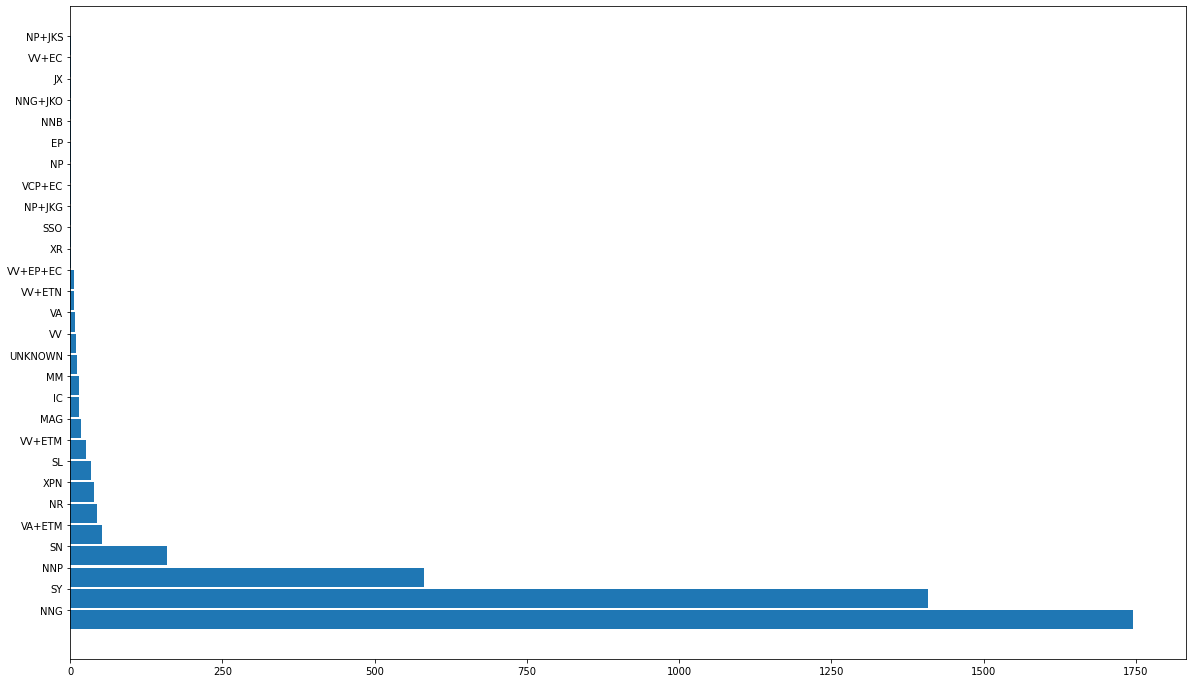

In [172]:
labels, values = zip(*Counter(start_pumsa_tagging).items())

indexes = np.arange(len(labels))
width = 0.9

plt.figure(figsize=(20, 12))
plt.barh(indexes, sorted(values, reverse=True), width, )
plt.yticks(indexes + width * 0.5, labels)
plt.show()

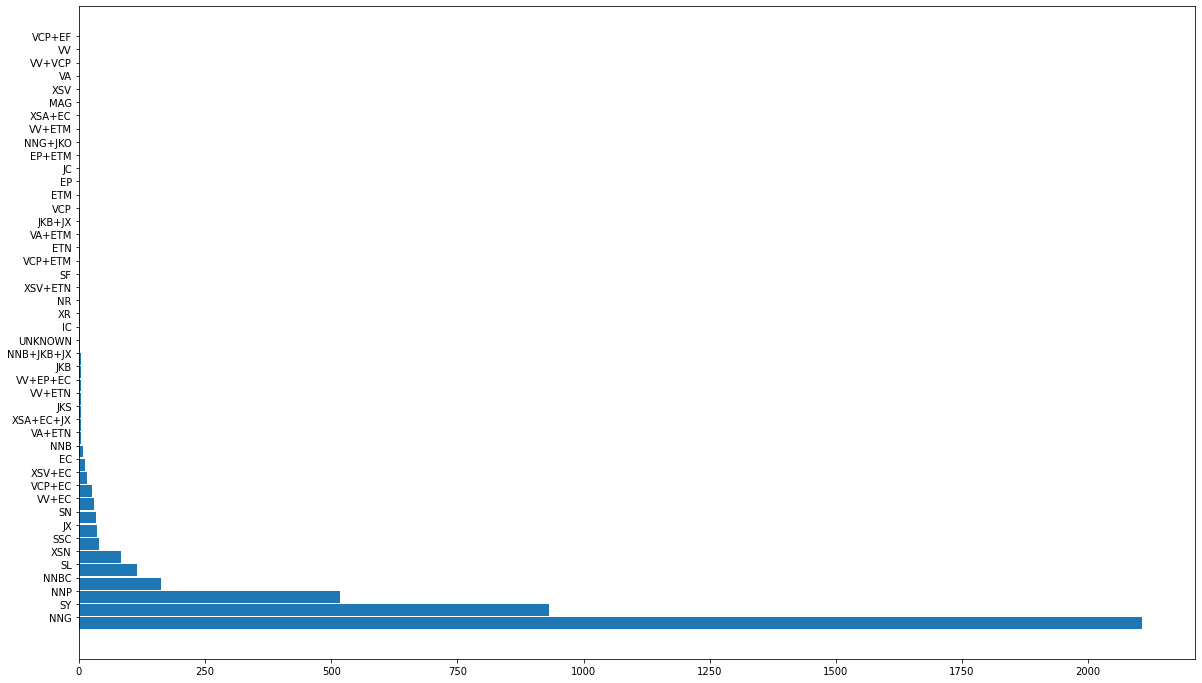

In [173]:
labels, values = zip(*Counter(end_pumsa_tagging).items())

indexes = np.arange(len(labels))
width = 0.9

plt.figure(figsize=(20, 12))
plt.barh(indexes, sorted(values, reverse=True), width, )
plt.yticks(indexes + width * 0.5, labels)
plt.show()

In [174]:
for pt in pumsa_tagging:
    if "J" in pt[-1][1]:
        print(pt)

[('1907', 'SN'), ('년', 'NNBC'), ('까지', 'JX')]
[('예수', 'NNP'), ('그리스', 'NNP'), ('도', 'JX')]
[('트', 'VV'), ('랴', 'EC'), ('피', 'XR'), ('친', 'XSA+EC+JX')]
[('만화', 'NNG'), ('가', 'JKS')]
[('16', 'SN'), ('년', 'NNBC'), ('만', 'JX')]
[('개인', 'NNG'), ('적', 'XSN'), ('인', 'VCP+ETM'), ('차원', 'NNG'), ('의', 'JKG'), ('후원', 'NNG'), ('이', 'VCP'), ('었', 'EP'), ('기', 'ETN'), ('때문', 'NNB'), ('에', 'JKB')]
[('백인', 'NNG'), ('들', 'XSN'), ('은', 'JX'), ('추장', 'NNG'), ('을', 'JKO'), ('‘', 'SY'), ('부족', 'NNG'), ('지배자', 'NNG'), ('’', 'SY'), ('라고', 'JKQ'), ('믿', 'VV'), ('고', 'EC'), ('있', 'VX'), ('기', 'ETN'), ('때문', 'NNB'), ('에', 'JKB')]
[('드레스', 'NNG'), ('덴', 'NNB+JKB+JX')]
[('영산회상', 'NNG'), ('도', 'JX')]
[('마루노우치', 'NNP'), ('선', 'JKB+JX')]
[('1525', 'SN'), ('년', 'NNBC'), ('까지', 'JX')]
[('북위', 'NNG'), ('50', 'SN'), ('도', 'NNBC'), ('이남', 'NNG'), ('의', 'JKG'), ('사할린', 'NNP'), ('섬', 'NNG'), ('및', 'MAJ'), ('조차지', 'NNG'), ('요동', 'NNG'), ('반', 'NNG'), ('도', 'JX')]
[('건강', 'NNG'), ('질', 'XSN'), ('의서', 'JKB')]
[('스', 'VV'), ('

# Question과 Context쌍 사이의 겹치는 토큰 비율 분석

In [25]:
context_tokens = tokenizer.tokenize(train_data["train"]["context"][0])
context_tokens

['미국',
 '상의',
 '##원',
 '또는',
 '미국',
 '상원',
 '(',
 'United',
 'State',
 '##s',
 'Se',
 '##n',
 '##ate',
 ')',
 '은',
 '양',
 '##원',
 '##제',
 '##인',
 '미국',
 '의회',
 '##의',
 '상원',
 '##이다',
 '.',
 '[UNK]',
 'n',
 '[UNK]',
 'n',
 '##미',
 '##국',
 '부통령',
 '##이',
 '상원',
 '##의',
 '##장이',
 '된다',
 '.',
 '각',
 '주당',
 '2',
 '##명',
 '##의',
 '상원',
 '##의원',
 '##이',
 '선출',
 '##되',
 '##어',
 '100',
 '##명',
 '##의',
 '상원',
 '##의원',
 '##으로',
 '구성',
 '##되',
 '##어',
 '있',
 '##다',
 '.',
 '임기',
 '##는',
 '6',
 '##년',
 '##이',
 '##며',
 ',',
 '2',
 '##년',
 '##마다',
 '50',
 '##개',
 '##주',
 '중',
 '1',
 '/',
 '3',
 '##씩',
 '상원',
 '##의원',
 '##을',
 '새로',
 '선출',
 '##하여',
 '연방',
 '##에',
 '보낸다',
 '.',
 '[UNK]',
 'n',
 '[UNK]',
 'n',
 '##미',
 '##국',
 '상원',
 '##은',
 '미국',
 '하원',
 '##과',
 '##는',
 '다르',
 '##게',
 '미국',
 '대통령',
 '##을',
 '수반',
 '##으로',
 '하',
 '##는',
 '미국',
 '연방',
 '행정부',
 '##에',
 '각종',
 '동의',
 '##를',
 '하',
 '##는',
 '기관',
 '##이다',
 '.',
 '하원',
 '##이',
 '세금',
 '##과',
 '경제',
 '##에',
 '대한',
 '권한',
 ',',
 '대통령',
 '##을',
 

In [26]:
question_tokens = tokenizer.tokenize(train_data["train"]["question"][0])
question_tokens

['대통령',
 '##을',
 '포함',
 '##한',
 '미국',
 '##의',
 '행정부',
 '견제',
 '##권',
 '##을',
 '갖',
 '##는',
 '국가',
 '기관',
 '##은',
 '?']

In [27]:
same_tokens = 0
for qt in question_tokens:
    if qt in context_tokens:
        same_tokens += 1
same_tokens, same_tokens/len(question_tokens) * 100

(14, 87.5)

In [28]:
train_contexts = train_data["train"]["context"]
train_questions = train_data["train"]["question"]
validation_contexts = train_data["validation"]["context"]
validation_questions = train_data["validation"]["question"]

In [29]:
train_same_tokens_ratio = []
for idx, train_question in enumerate(tqdm(train_questions)):
    train_same_tokens = 0
    train_question_tokens = tokenizer.tokenize(train_question)
    for token in train_question_tokens:
        if token in tokenizer.tokenize(train_contexts[idx]):
            train_same_tokens += 1

    train_same_tokens_ratio.append(train_same_tokens / len(train_question_tokens))

np.mean(train_same_tokens_ratio)


100%|██████████| 3952/3952 [01:41<00:00, 38.95it/s]


0.7046181078015276

In [30]:

validation_same_tokens_ratio = []
for idx, validation_question in enumerate(tqdm(validation_questions)):
    validation_same_tokens = 0
    validation_question_tokens = tokenizer.tokenize(validation_question)
    for token in validation_question_tokens:
        if token in tokenizer.tokenize(validation_contexts[idx]):
            validation_same_tokens += 1
    
    validation_same_tokens_ratio.append(validation_same_tokens/len(validation_question_tokens))

np.mean(validation_same_tokens_ratio)

100%|██████████| 240/240 [00:06<00:00, 39.65it/s]


0.704813004825963

(array([   2.,    2.,   15.,   59.,  250.,  732., 1158., 1195.,  470.,
          69.]),
 array([0.1 , 0.19, 0.28, 0.37, 0.46, 0.55, 0.64, 0.73, 0.82, 0.91, 1.  ]),
 <BarContainer object of 10 artists>)

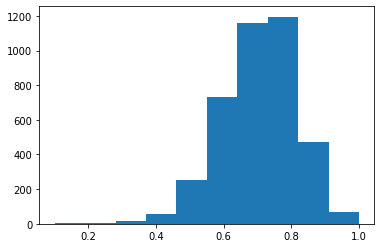

In [31]:
plt.hist(train_same_tokens_ratio)

(array([ 1., 14., 16., 27., 40., 62., 44., 24., 10.,  2.]),
 array([0.38461538, 0.44615385, 0.50769231, 0.56923077, 0.63076923,
        0.69230769, 0.75384615, 0.81538462, 0.87692308, 0.93846154,
        1.        ]),
 <BarContainer object of 10 artists>)

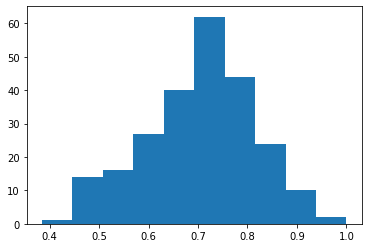

In [32]:
plt.hist(validation_same_tokens_ratio)